https://velog.io/@euisuk-chung/%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98-%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98%EB%A1%9C-CNN-%EB%AA%A8%EB%8D%B8%EC%9D%84-%EA%B5%AC%ED%98%84%ED%95%B4%EB%B3%B4%EC%9E%90-%EA%B8%B0%EC%B4%88%ED%8E%B8-DataLoader-%EC%82%AC%EC%9A%A9%EB%B2%95

In [1]:
import torch
import torch.nn as nn # 신경망
import torch.optim as optim # 최적화 알고리즘
import torch.nn.init as init # 텐서 초기값 배정

import torchvision.datasets as datasets # 이미지 데이터셋
import torchvision.transforms as transforms # 이미지 변환툴

from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴

import numpy as np
import matplotlib.pyplot as plt

In [2]:
batch_size = 100
learning_rate = 0.0002
num_epoch = 10

In [3]:
mnist_train = datasets.MNIST(root="C:/Users/rohgo/python/DL/Data/", train=True, 
                             transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = datasets.MNIST(root="C:/Users/rohgo/python/DL/Data/", train=False, 
                             transform=transforms.ToTensor(), target_transform=None, download=True)

In [4]:
# mnist_train은 60000개의 tuple을 들고있다.
# 각 tuple에는 하나의 텐서(이미지)와 하나의 라벨이 들어있다.
print(type(mnist_train))
print(len(mnist_train))

print(type(mnist_train[0]))
print(len(mnist_train[0]))

# print(mnist_train[0])

<class 'torchvision.datasets.mnist.MNIST'>
60000
<class 'tuple'>
2


In [5]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last = True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, num_workers=2, drop_last = True)

<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([1, 28, 28])
torch.Size([])
torch.Size([1, 28, 28])
torch.float32
label is :  tensor(6)


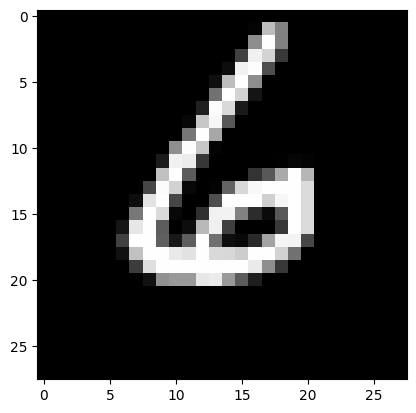

In [6]:
print(type(train_loader))

image = 0
label = 0

for j, [img, lab] in enumerate(train_loader):
    image = img[0]
    label = lab[0]
    break
    
print(image.shape)
print(label.shape)
print(image.shape)
print(image.dtype)
print('label is : ', label)

plt.imshow(image.permute(1, 2, 0), cmap='gray')
plt.show()

In [7]:
class CNN(nn.Module):
    def __init__(self):
        # super 함수로 CNN 클래스의 부모 클래스인 nn.modules를 초기화
        super(CNN, self).__init__()
        
        # batch_size = 100
        self.layer = nn.Sequential(
            # [100, 1, 28, 28] -> [100, 16, 24, 24]
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
            nn.ReLU(),

            # [100, 16, 24, 24] -> [100, 32, 20, 20]
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
            nn.ReLU(),

            # [100, 32, 20, 20] -> [100, 32, 10, 10]
            nn.MaxPool2d(kernel_size=2, stride=2),

            # [100, 32, 10, 10] -> [100, 64, 6, 6]
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
            nn.ReLU(),

            # [100, 64, 6, 6] -> [100, 64, 3, 3]
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layer = nn.Sequential(
            # [100, 64*3*3]-> [100, 100]
            nn.Linear(64*3*3, 100),
            nn.ReLU(),

            # [100, 100] -> [100, 10]
            nn.Linear(100, 10)
        )
    
    def forward(self, x):
        # self.layer에서 정의된 연산 실행
        out = self.layer(x)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)
        
        return out
        

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
model = CNN().to(device)

In [10]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
loss_arr = []
for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader):
        x = image.to(device)
        y = label.to(device)
        
        optimizer.zero_grad()
        
        output = model.forward(x)
        
        loss = loss_func(output, y)
        loss.backward()
        optimizer.step()
        
        if j%1000 == 0:
            print(loss)
            loss_arr.append(loss.cpu().detach().numpy())

tensor(2.3010, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1171, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0743, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0451, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0306, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0407, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0481, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0130, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0228, device='cuda:0', grad_fn=<NllLossBackward0>)


In [12]:
correct = 0
total = 0

# evaluate model
model.eval()

with torch.no_grad():
    for image, label in test_loader:
        x = image.to(device)
        y = label.to(device)
        
        output = model.forward(x)
        
        # torch.max 함수는 (절댓값, index)를 반환
        _, output_index = torch.max(output, 1)
        
        # 전체개수 += 라벨의 개수
        total += label.size(0)
        
        # 도출한 모델의 index와 라벨이 일치하면 correct에 추가
        correct += (output_index == y).sum().float()
        
# 정확도 계산
print(f'Accuracy of Test Data is {100*correct/total}%')

Accuracy of Test Data is 99.11000061035156%
